In [2]:
import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import sinc
from scipy.signal._arraytools import _validate_fs
import scipy.signal as signal

In [3]:
def firwin(numtaps, cutoff, *, width=None, window='hamming', pass_zero=True, scale=True, fs=None):
    """
    FIR filter design using the window method.

    Parameters
    ----------
    numtaps : int
        Length of the filter (number of coefficients, i.e. the filter
        order + 1).  `numtaps` must be odd if a passband includes the
        Nyquist frequency.
    cutoff : float or 1-D array_like
        Cutoff frequency of filter (expressed in the same units as `fs`)                        
        OR an array of cutoff frequencies (that is, band edges). In the
        latter case, the frequencies in `cutoff` should be positive and
        monotonically increasing between 0 and `fs/2`. The values 0 and
        `fs/2` must not be included in `cutoff`.
    width : float or None, optional
        If `width` is not None, then assume it is the approximate width
        of the transition region (expressed in the same units as `fs`)
        for use in Kaiser FIR filter design. In this case, the `window`
        argument is ignored.
    window : string or tuple of string and parameter values, optional
        Desired window to use. See `scipy.signal.get_window` for a list
        of windows and required parameters.
    pass_zero : {True, False, 'bandpass', 'lowpass', 'highpass', 'bandstop'}, optional
        If True, the gain at the frequency 0 (i.e., the "DC gain") is 1.
        If False, the DC gain is 0. Can also be a string argument for the
        desired filter type (equivalent to ``btype`` in IIR design functions).
    fs : float, optional
        The sampling frequency of the signal. Each frequency in `cutoff`
        must be between 0 and ``fs/2``.  Default is 2.

    Returns
    -------
    h : (numtaps,) ndarray
        Coefficients of length `numtaps` FIR filter.
    """
    fs = _validate_fs(fs, allow_none=True)
    fs = 2 if fs is None else fs

    nyq = 0.5 * fs

    cutoff = np.atleast_1d(cutoff) / float(nyq)

    if isinstance(pass_zero, str):
        if pass_zero in ('bandstop', 'lowpass'):
            if pass_zero == 'lowpass':
                if cutoff.size != 1:
                    raise ValueError('cutoff must have one element if '
                                     f'pass_zero=="lowpass", got {cutoff.shape}')
            elif cutoff.size <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 f'pass_zero=="bandstop", got {cutoff.shape}')
            pass_zero = True
        elif pass_zero in ('bandpass', 'highpass'):
            if pass_zero == 'highpass':
                if cutoff.size != 1:
                    raise ValueError('cutoff must have one element if '
                                     f'pass_zero=="highpass", got {cutoff.shape}')
            elif cutoff.size <= 1:
                raise ValueError('cutoff must have at least two elements if '
                                 f'pass_zero=="bandpass", got {cutoff.shape}')
            pass_zero = False
        else:
            raise ValueError('pass_zero must be True, False, "bandpass", '
                             '"lowpass", "highpass", or "bandstop", got '
                             f'{pass_zero}')
    pass_zero = bool(operator.index(pass_zero))  # ensure bool-like

    pass_nyquist = bool(cutoff.size & 1) ^ pass_zero
    if pass_nyquist and numtaps % 2 == 0:
        raise ValueError("A filter with an even number of coefficients must "
                         "have zero response at the Nyquist frequency.")

    # Insert 0 and/or 1 at the ends of cutoff so that the length of cutoff
    # is even, and each pair in cutoff corresponds to passband.
    cutoff = np.hstack(([0.0] * pass_zero, cutoff, [1.0] * pass_nyquist))

    # `bands` is a 2-D array; each row gives the left and right edges of a passband.
    bands = cutoff.reshape(-1, 2)

    # Build up the coefficients.
    alpha = 0.5 * (numtaps - 1)
    m = np.arange(0, numtaps) - alpha
    h = 0
    for left, right in bands:
        h += right * sinc(right * m)
        h -= left * sinc(left * m)

    # Get and apply the window function.
    win = signal.get_window(window, numtaps, fftbins=False)
    h *= win

    # Now handle scaling if desired.
    if scale:
        # Get the first passband.
        left, right = bands[0]
        if left == 0:
            scale_frequency = 0.0
        elif right == 1:
            scale_frequency = 1.0
        else:
            scale_frequency = 0.5 * (left + right)
        c = np.cos(np.pi * m * scale_frequency)
        s = np.sum(h * c)
        h /= s

    return h

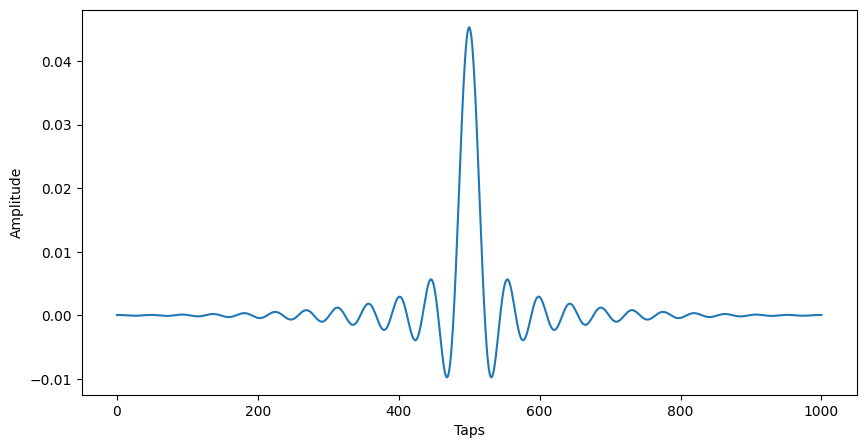

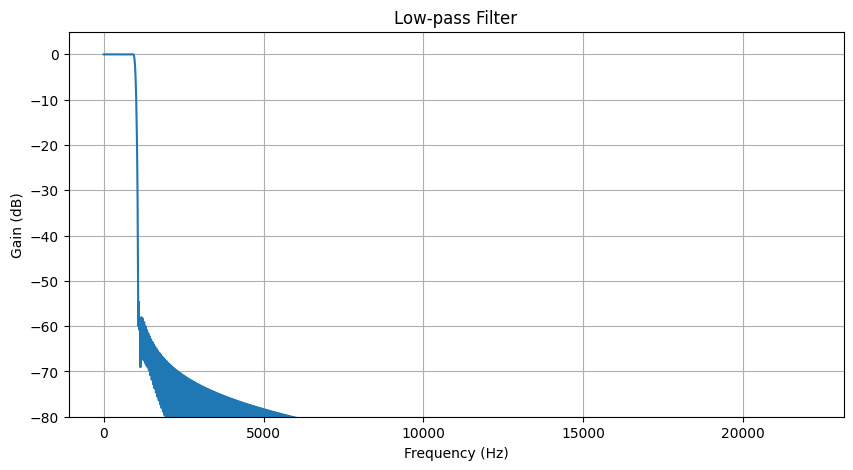

In [7]:
def plot_freq_response(w, h, title):
  "Utility function to plot frequency response functions"
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  ax.plot(w, 20*np.log10(np.abs(h)))
  ax.set_ylim(-80, 5)
  ax.grid(True)
  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Gain (dB)')
  ax.set_title(title)

# design a low pass filter
fs = 44100.0
filter_length = 101
cutoff = 1000
h = firwin(filter_length, cutoff, window='hamming', fs=fs)

plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')
plt.show()

w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Low-pass Filter")
plt.show()